In [53]:
from utils import make_need_tree,visualize_tree,make_storage,make_requirement_tree,find_by_name

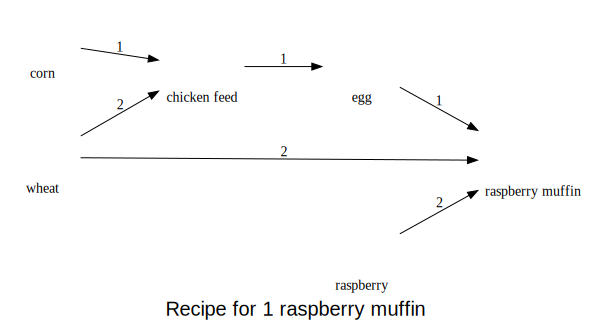

In [69]:
tree = make_need_tree('Raspberry muffin',1)
visualize_tree(tree)

In [70]:
storage = make_storage(100)
req_tree=make_requirement_tree('raspberry muffin',storage)
req_tree

{'name': 'raspberry muffin',
 'quantity': 1,
 'children': [{'name': 'egg',
   'quantity': 1,
   'children': [{'name': 'chicken feed',
     'quantity': 1,
     'children': [{'name': 'corn', 'quantity': 1, 'children': []},
      {'name': 'wheat', 'quantity': 2, 'children': []}]}]},
  {'name': 'raspberry', 'quantity': 2, 'children': []},
  {'name': 'wheat', 'quantity': 2, 'children': []}]}

In [74]:
count = 0

def make_task_list(tree):
    global count
    tasks = []
    for _ in range(tree['quantity']):
        count+=1
        task = {
            'id':count,
            'name':tree['name'],
            'dependencies':[], # id of dependencies tasks
        }
        tasks.append(task)
        for child in tree['children']:
            temp = make_task_list(child)
            tasks.extend(temp)
            # add dependencies
            task['dependencies'].extend([t['id'] for t in temp[:child['quantity']]])
    return tasks
make_task_list(req_tree)

[{'id': 1, 'name': 'raspberry muffin', 'dependencies': [2, 7, 8, 9, 10]},
 {'id': 2, 'name': 'egg', 'dependencies': [3]},
 {'id': 3, 'name': 'chicken feed', 'dependencies': [4, 5, 6]},
 {'id': 4, 'name': 'corn', 'dependencies': []},
 {'id': 5, 'name': 'wheat', 'dependencies': []},
 {'id': 6, 'name': 'wheat', 'dependencies': []},
 {'id': 7, 'name': 'raspberry', 'dependencies': []},
 {'id': 8, 'name': 'raspberry', 'dependencies': []},
 {'id': 9, 'name': 'wheat', 'dependencies': []},
 {'id': 10, 'name': 'wheat', 'dependencies': []}]